<a href="https://colab.research.google.com/github/bivekpok/DSPS_BPokhrel/blob/main/HW5/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [1]:
import pandas as pd
import pylab as pl
%pylab inline
from sklearn.model_selection import train_test_split
import numpy as np




Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [2]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")
grbAG.head()


,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [3]:
grbAG.tail()

,filter,time,mag,magerr,upperlimit
114,W1,63738,21.20,NaN,1
115,M2,74798,21.59,NaN,1
116,U,128928,20.05,NaN,1
117,V,971360,22.09,NaN,1
118,V,1171176,21.16,NaN,1


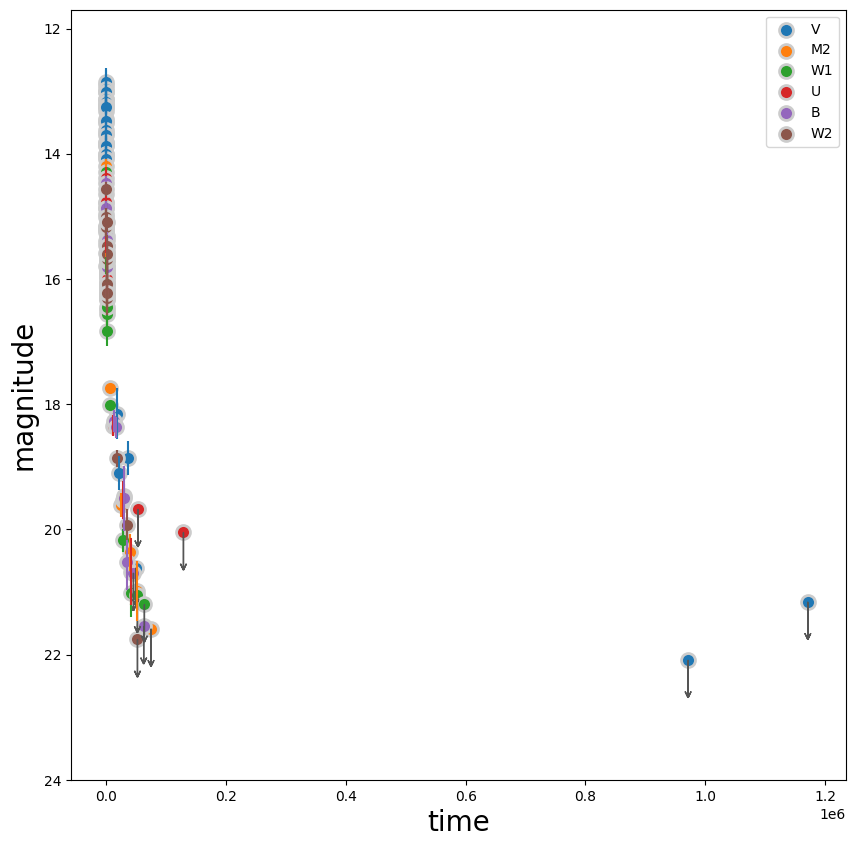

In [4]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

## Fig: The plot of magnitude and the time from grbAG dataset. This shows the relatiionship with time . Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [5]:
grbAG['logtime'] = np.log10(grbAG['time'])
grbAG

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098
...,...,...,...,...,...,...
114,W1,63738,21.20,NaN,1,4.804398
115,M2,74798,21.59,NaN,1,4.873890
116,U,128928,20.05,NaN,1,5.110347
117,V,971360,22.09,NaN,1,5.987380


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [6]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

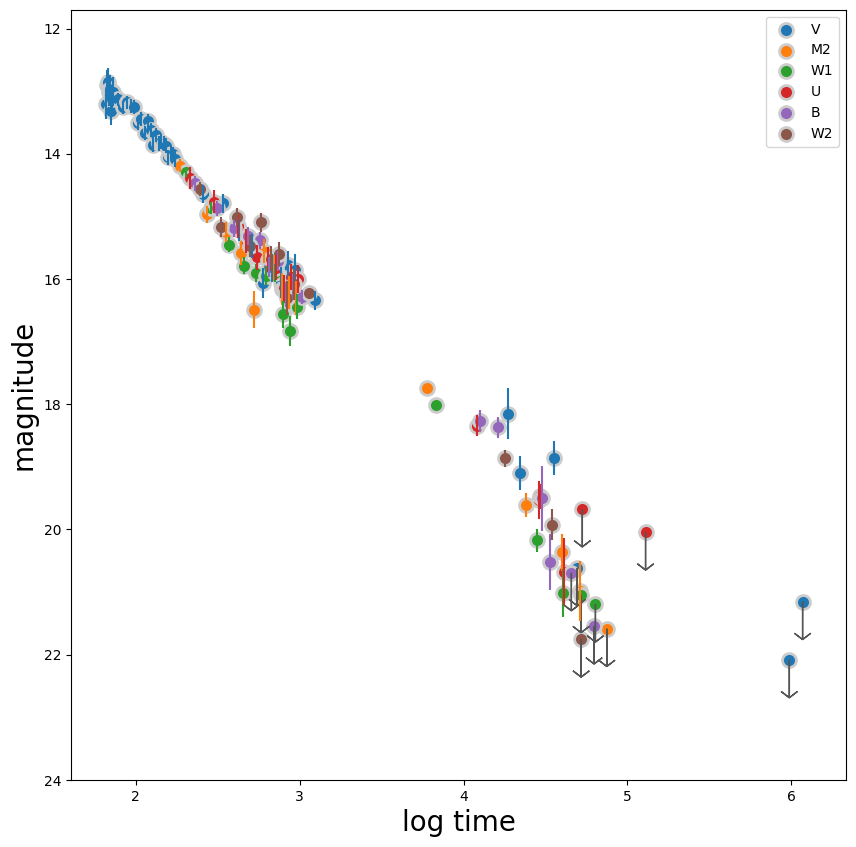

In [7]:
plotlogtime(grbAG)

Figure 1:Scatter plot of magnitude of the light and logtime.Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [8]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [9]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [10]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
par = lr.fit(X,y)
print(f'the parameters are intercept: { par.intercept_:.2f} and slope:  { (par.coef_[1]):.2f}')


the parameters are intercept: 8.58 and slope:  2.51


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [11]:
def line(intercept, slope, x):
    return intercept+ slope*x

In [12]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize


def l1(args, x, y):
    slope, intercept = args
    y0 = line(slope, intercept, x)
    f = abs(y - y0)
    return np.sum(f)

initial_guess = (8.0, 1.25)  # Provide initial guesses for slope and intercept

l1Solution = minimize(l1, initial_guess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.30332700616399
        x: [ 8.225e+00  2.641e+00]
      nit: 17
      jac: [-6.664e-02 -2.025e+00]
 hess_inv: [[ 1.719e-04 -4.073e-05]
            [-4.073e-05  9.654e-06]]
     nfev: 318
     njev: 102

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [13]:

def l2(args, x, y):
  '''l2 target function: returns value of l2 for given arguments and data for a line model
  arg: (array) model arguments (parameters)
  x: the exogenous variable (array)
  y: the exogenous variable (array)
  returns L2 sum of difference between prediction and data squared
  '''
  slope, intercept = args
  y0 = line(slope, intercept, x)
  f = (y - y0)**2
  return np.sum(f)

initial_guess = (8.0, 1.25)

l2Solution = minimize(l2, initial_guess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.82598750072556
        x: [ 8.583e+00  2.512e+00]
      nit: 5
      jac: [ 0.000e+00  1.192e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 21
     njev: 7

best fit parameters from the minimization of L2: slope 8.58, intercept 2.51



# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [14]:
def chi2(args, x, y, s):
  slope, intercept = args
  slope, intercept = args
  y0 = line(slope, intercept, x)
  f = (y - y0)**2* 1/s**2

  return np.sum(f)





x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initial_guess = (8.0, 1.25)

chi2Solution = minimize(chi2, initial_guess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.42066980129886
        x: [ 8.599e+00  2.480e+00]
      nit: 5
      jac: [-7.629e-06  1.831e-04]
 hess_inv: [[ 1.559e-03 -5.429e-04]
            [-5.429e-04  2.017e-04]]
     nfev: 102
     njev: 30

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


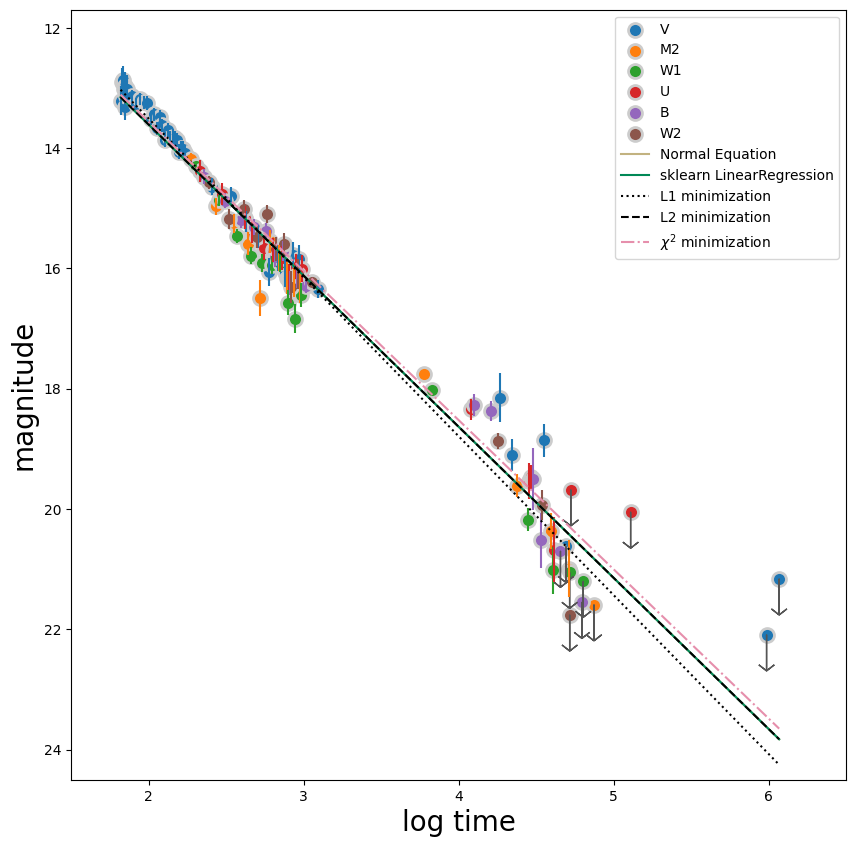

In [15]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1 and Chi squared. The models are indicated in the legend.

# HW part 1: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)
initial_guess = (10, 0.5)  # Provide initial guesses for slope and intercept
train_par = minimize(l1, initial_guess, args=(x_train, y_train))
train_par_l2 = minimize(l2, initial_guess, args= (x_train, y_train))
# chi2Solution = minimize(chi2, initial_guess, args=(x, y, s))

print(f' the par : {train_par}')
print(f'the par_l2 : {train_par_l2}')

 the par :   message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 20.75726229738507
        x: [ 8.397e+00  2.568e+00]
      nit: 11
      jac: [ 5.808e-01  1.781e+00]
 hess_inv: [[ 2.105e-03 -7.213e-04]
            [-7.213e-04  2.712e-04]]
     nfev: 249
     njev: 79
the par_l2 :   message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 10.406886415354588
        x: [ 8.659e+00  2.484e+00]
      nit: 4
      jac: [ 8.345e-07 -1.192e-06]
 hess_inv: [[ 7.956e-02 -2.517e-02]
            [-2.517e-02  8.634e-03]]
     nfev: 18
     njev: 6


In [17]:
print(f' Score for the whole set : { lr.score(X, y):.4f}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f' Score for the train set : { lr.score(X_train, y_train):.4f}')
print(f' Score for the test set : { lr.score(X_test, y_test):.4f}')



 Score for the whole set : 0.9719
 Score for the train set : 0.9716
 Score for the test set : 0.9708


# Now try a line to the data with MCMC

# HW part 2: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [18]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 628.9 kB/s eta 0:00:00


In [19]:
import emcee #import the package

In [20]:
emcee

<module 'emcee' from '/usr/local/lib/python3.10/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters: $P(\theta | D) ~ P(D | \theta) * P(\theta)$ or _Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



In [21]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [22]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [23]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [24]:
#initial guess
ig = [1,10]

In [25]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [26]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess

In [27]:
pos.shape

(32, 2)

In [28]:
# theta = (8.52,2.5)
# log_probability= log_posterior(theta, x, y, s)

In [29]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x,y,s))

In [30]:

sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:17<00:00, 288.37it/s]


In [31]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [32]:
samples.shape

(5000, 32, 2)

In [33]:
# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [34]:
#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[2.46554225, 2.47990108, 2.49381664],
       [8.56142861, 8.60059318, 8.63969435]])

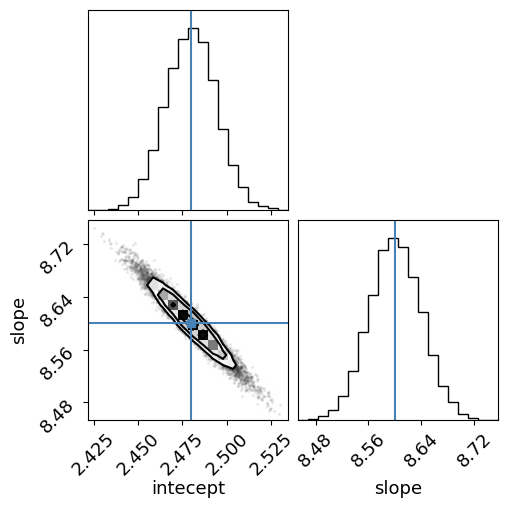

In [35]:
#plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters
!pip install corner
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intecept", "slope"], truths=mcmc[:,1]);


## Fig: Corner Plot of Posterior Distributions: 2D Projections and 1D Marginalized Probabilities"

This figure shows the 2D projections of the parameter space and 1D marginalized probability distributions for each parameter. It use of truths to indicate the true values as the mean of the flattened space (assuming "mcmc" contains true parameter values).

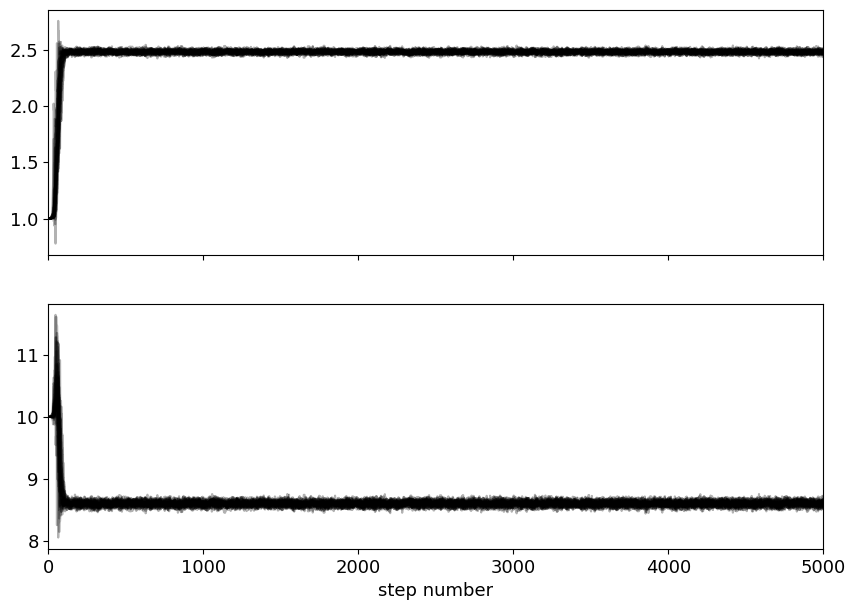

In [36]:
# the chains should be plotted as well. in the slides and in class I discuss what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

## Fig: MCMC Chain Evolution: Exploration of Parameter Space
This caption conveys that the figure displays the evolution of the Markov Chain Monte Carlo (MCMC) chains for each parameter (intercept and slope). It suggests to observe how the chains explore the parameter space and how they evolve over the course of the MCMC simulation.

(5000, 32, 2)


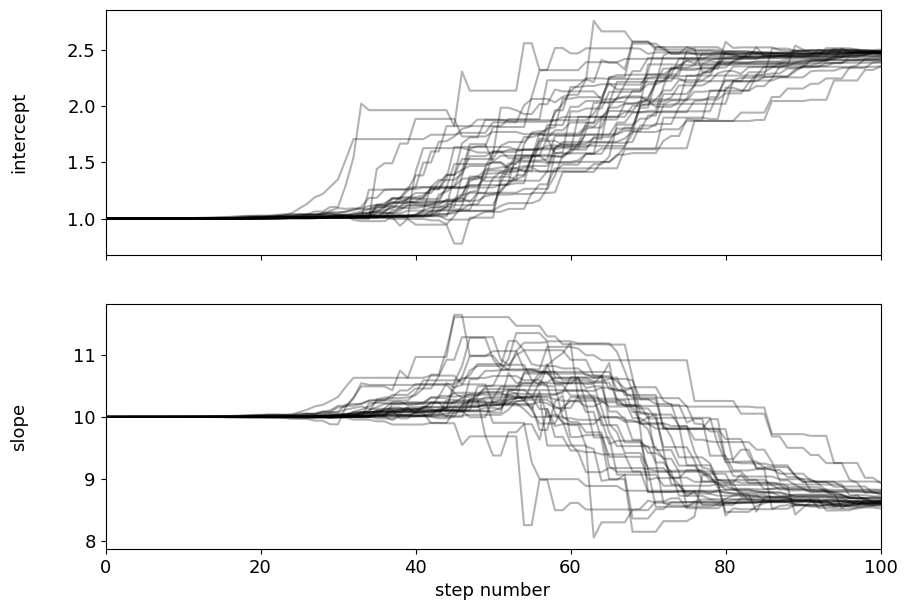

In [37]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i == 0:
      ax.set_ylabel('intercept')
    if i == 1:
      ax.set_ylabel('slope')

axes[-1].set_xlabel("step number");

In [38]:
# save the mcmc results for later
mcmc_line = mcmc

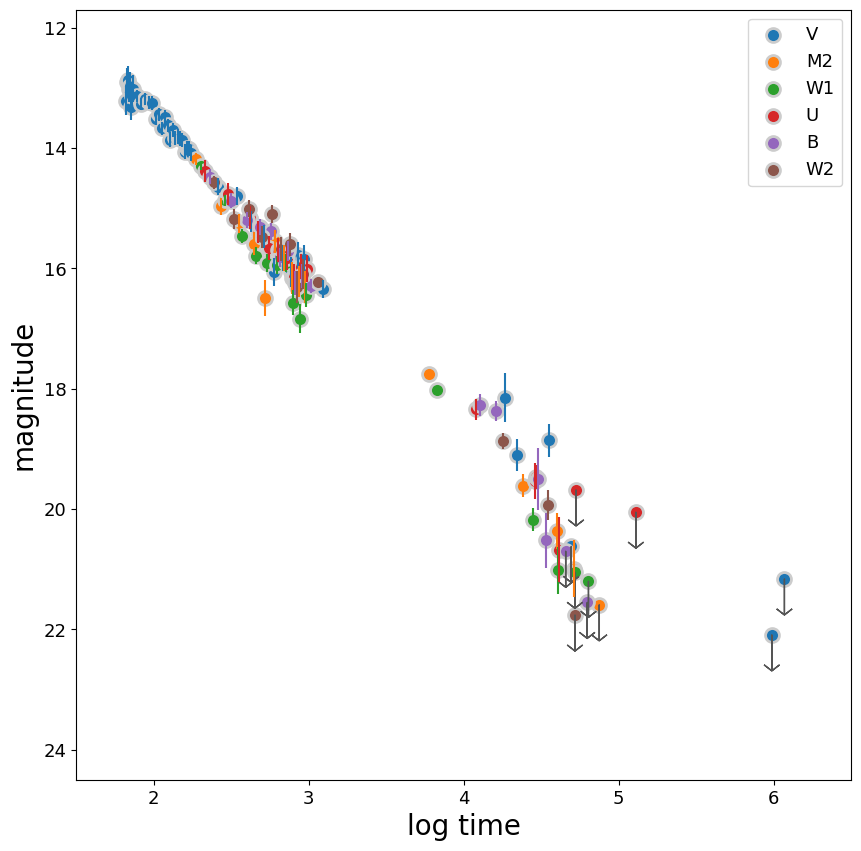

In [39]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

# ax.plot(np.arange(1.5,6,0.01),
#         bpl(ig, 10**np.arange(1.5,6,0.01)), ls="--", c="k",
#         label="MCMC")

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$


$b - log_{10}((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2}) $



In [40]:
t = grbAG[grbAG.upperlimit == 0].time.values
x = grbAG[grbAG.upperlimit == 0].logtime.values

In [41]:
t.min(), t.max()

(66, 51257)

In [42]:
l_mag = -2.5*np.log10(grbAG[grbAG.upperlimit ==0].mag.values)
l_mag_err = -2.5*np.log10(grbAG[grbAG.upperlimit ==0].magerr.values)

In [43]:
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

In [44]:
import pandas as pd

# Check for NaN in l_mag
has_nan_l_mag = grbAG[grbAG.upperlimit == 0].mag.isna()

# Check for NaN in l_mag_err
has_nan_l_mag_err = grbAG[grbAG.upperlimit == 0].magerr.isna()

# Check if there are any NaN values in l_mag and l_mag_err
if has_nan_l_mag.any():
    print("l_mag contains NaN values.")
else:
    print("l_mag does not contain NaN values.")

if has_nan_l_mag_err.any():
    print("l_mag_err contains NaN values.")
else:
    print("l_mag_err does not contain NaN values.")


l_mag does not contain NaN values.
l_mag_err does not contain NaN values.


# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [45]:
# def bpl (theta, t):
#   """broken power law model
#   Input:
#     theta: (array like) 4 parameters vector, see equation
#     x: (array like) independent variable
#   Return:
#     model predictions for each x (array like)
#   """

#   Tb, a1, a2, b = theta
#   return b - np.log10((t/Tb)**(-a1)+ (t/Tb)**(-a2))
# # Define the log-likelihood function
# def log_likelihood_bpl(theta, l_mag, l_mag_err, t):

#     model = bpl(theta, t)
#     # Assuming Gaussian uncertainties
#     # sigma = 0.1  # Adjust as needed
#     return -0.5 * np.sum((l_mag - model) ** 2 / l_mag_err ** 2)

# # Define the log-prior function
# def log_prior_bpl(theta):
#     Tb, a1, a2, b = theta
#     # Define prior bounds here, adjust as needed
#     if  0 < Tb<10000  and -10 < a1 < 10 and -10 < a2 < 10:
#     # if 65<Tb<51257:
#         return 0.0  # Within bounds
#     return -np.inf  # Outside bounds

# # Define the log-posterior function
# def log_posterior_bpl(theta, l_mag, l_mag_err, t):
#     lp = log_prior_bpl(theta)
#     if not np.isfinite(lp):
#         return -np.inf  # Log-prior is infinite, so log-posterior is also infinite
#     ll = log_likelihood_bpl(theta, l_mag, l_mag_err, t)
#     if not np.isfinite(ll):
#         return -np.inf  # Log-likelihood is infinite, so log-posterior is also infinite
#     return lp + ll  # L
# def bpl(theta, t):
#     """broken power law model
#     Input:
#       theta: (array like) 4 parameters vector, see equation
#       x: (array like) independent variable
#     Return:
#       model predictions for each x (array like)
#     """
#     Tb, a1, a2, b = theta
#     tmp = (t / Tb)
#     F = ((tmp ** -a1) + (tmp ** -a2))
#     return b - np.log10(F)
# def bpl (theta, x):
#   """broken power law model
#   Input:
#     theta: (array like) 4 parameters vector, see equation
#     x: (array like) independent variable
#   Return:
#     model predictions for each x (array like)
#   """

#   Tb, a1, a2, b = theta
#   return b - np.log10((x/Tb)**(-a1)+ (x/Tb)**(-a2))

# def log_likelihood_bpl(theta, x, y_obs, y_err):
#     y_model = bpl(theta, x)

#     chi2 = np.sum(((y_obs - y_model) / y_err)**2)
#     return -0.5 * chi2  # Return negative half chi-squared as the log-likelihood

# def log_prior_bpl(theta):
#     Tb, a1, a2, b = theta
#     if 0 < Tb < 100000 and -10 < a1 < 10 and -10 < a2 < 10 and -10000 < b < 10000:
#         return 0  # Log of 1 for uniform prior
#     return -np.inf  # Log of 0 outside the reasonable range

# def log_posterior_bpl(theta, x, y_obs, y_err):
#     log_pri = log_prior_bpl(theta)
#     if not np.isfinite(log_pri):
#         return -np.inf
#     return log_pri + log_likelihood_bpl(theta, x, y_obs, y_err)
# def neg_log_likelihood_bpl(theta, x, y_obs, y_err):
#     return -log_likelihood_bpl(theta, x, y_obs, y_err)

# ig = [0.2, 5, 1000, 20]
# bounds = [(66, 51257), (-10, 10), (-10, 10), (-1000, 1000)]
# soln = minimize(neg_log_likelihood_bpl, ig, args=(t, y_obs, yerr), bounds=bounds)
# # soln = minimize(neg_log_likelihood_bpl, ig, args=(t, y, s))

# soln


In [46]:
def bpl (theta, x):
  """broken power law model
  Input:
    theta: (array like) 4 parameters vector, see equation
    x: (array like) independent variable
  Return:
    model predictions for each x (array like)
  """

  Tb, a1, a2, b = theta
  return b - np.log10((x/Tb)**(-a1)+ (x/Tb)**(-a2))
# Define the log-likelihood function
def log_likelihood_bpl(theta,x, y, y_err):
    Tb, a1, a2, b = theta
    model = bpl(theta, x)

    return -0.5 * np.sum(((y - model) / y_err)** 2)

# Define the log-prior function
def log_prior_bpl(theta):
    Tb, a1, a2, b = theta

    if  65<Tb<51257 and -70 < a1 < 70 and -70 < a2 < 70 and -1000 < b < 1000:
    # if 65<Tb<51257:
        return 0.0  # Within bounds
    return -np.inf  # Outside bounds

# Define the log-posterior function
def log_posterior_bpl(theta, x, y, y_err):
    lp = log_prior_bpl(theta)
    if not np.isfinite(lp):
        return -np.inf  # Log-prior is infinite, so log-posterior is also infinite
    ll = log_likelihood_bpl(theta,x, y, y_err)
    if not np.isfinite(ll):
        return -np.inf  # Log-likelihood is infinite, so log-posterior is also infinite
    return lp + ll  #
nll = lambda *args: -log_likelihood_bpl(*args)


# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [47]:
# Define the initial guess for the parameters
ig = [0.2, 5, 1000, 20]

bounds = [(66, 51257), (-100, 100), (-100, 100), (-1000, 1000)]
# Define the optimization function and pass additional arguments via 'args'
# soln = minimize(log_posterior_bpl, ig, args=(t, l_mag, l_mag_err), bounds =bounds)
soln = minimize(nll, ig, args=(t, y, s), bounds =bounds)

soln

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 108.7326573745178
        x: [ 2.736e+02  2.146e+00  3.548e+00  1.505e+01]
      nit: 70
      jac: [-2.842e-05 -1.447e-03  6.963e-04  1.057e-03]
     nfev: 680
     njev: 136
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

[273.55068919   2.14571725   3.54804791  15.04701152]


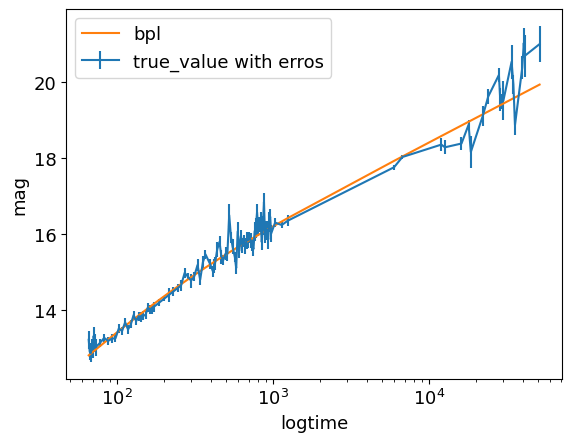

In [48]:
ig = soln.x # the initial guess for the MCMC
print(ig)

# plot the model as it looks with the initial guess values
pl.errorbar(t, y, s, label = 'true_value with erros')
pl.plot(t, bpl(ig, t), label = 'bpl')
pl.xlabel('logtime')
pl.ylabel('mag')
pl.xscale("log")
pl.legend()


## Fig4: plot of the logtime and magnitude using true value and bpl optimized model. Plot kinds of matches hinting towards the usefulness of the model.

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [49]:
# set the emcee hyperparameters


nwalkers, ndim = 32, len(ig)
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(t, y, s))

In [50]:
# run the model
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:30<00:00, 163.24it/s]


State([[280.97792248   2.09340319   3.45209319  15.09658036]
 [338.29734274   2.10516492   3.49730889  15.29836309]
 [545.05260246   2.02139632   3.2847008   15.86054635]
 [233.86522156   2.15995361   3.47895045  14.8616722 ]
 [491.87935817   2.01183579   3.29887916  15.74407273]
 [278.59883075   2.08987788   3.57594392  15.1010675 ]
 [358.44887828   2.0640514    3.44882857  15.36456115]
 [186.05728678   2.1993579    3.98370804  14.5656677 ]
 [470.39647013   2.05385968   3.19100229  15.66777182]
 [282.99130319   2.17347708   3.5157262   15.08656663]
 [481.20272238   2.07795858   3.33679431  15.71179656]
 [315.17322472   2.09957998   3.5625816   15.23251674]
 [358.96063294   2.10654422   3.55019671  15.38417141]
 [426.4196922    2.04723878   3.32201976  15.59697905]
 [253.58534093   2.16825187   3.59130649  14.96094543]
 [259.3992703    2.12856052   3.68760873  15.00255405]
 [257.72356197   2.15364217   3.72774256  14.98837476]
 [428.40568703   2.10032528   3.32046113  15.55912462]
 [33

(5000, 32, 4)


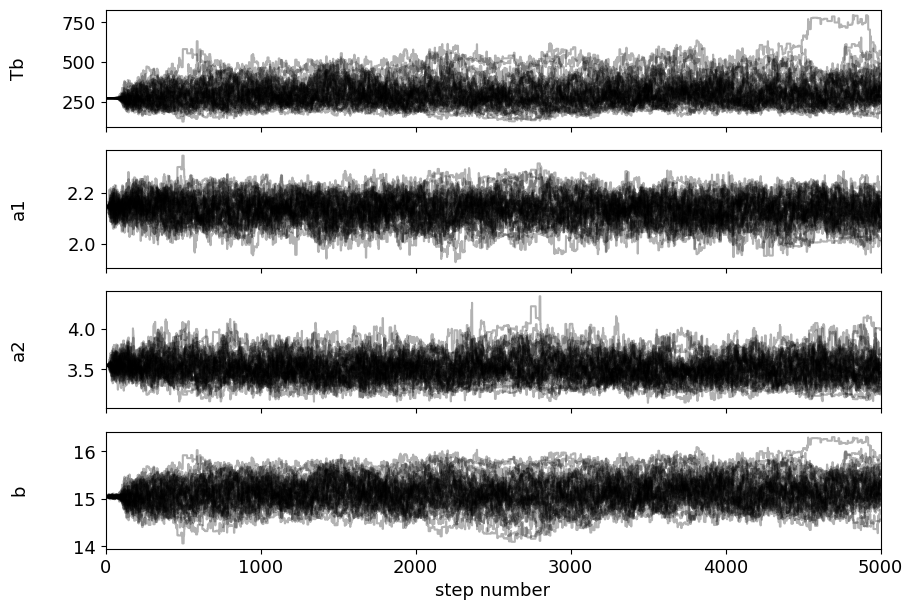

In [51]:
#plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ['Tb', 'a1', 'a2', 'b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [52]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile(flat_samples[:, i], [16, 50, 84])
mcmc

array([[226.35959129, 290.6137563 , 392.39583024],
       [  2.07811714,   2.13580066,   2.18845947],
       [  3.35368648,   3.50657061,   3.6719711 ],
       [ 14.81321452,  15.11975483,  15.47276796]])

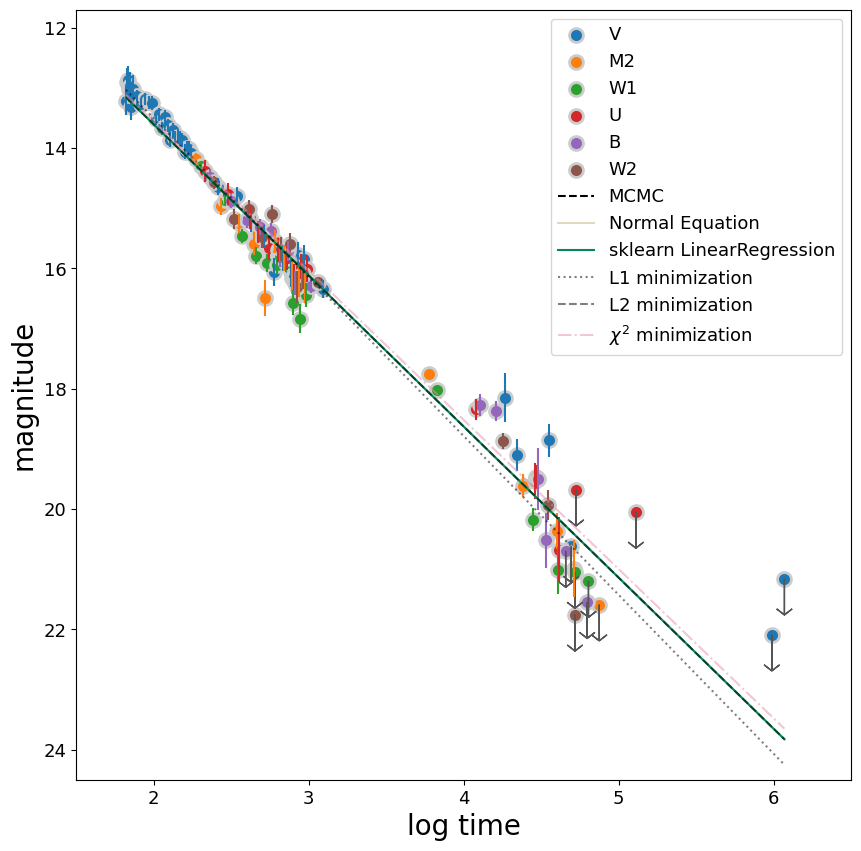

In [53]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.logtime.values, line(mcmc[:,1][0], mcmc[:,1][1],
                            grbAG.logtime.values), ls="--", c="k", label="MCMC")
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[2,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

## plot the marginalized posterior distributions of the parameters

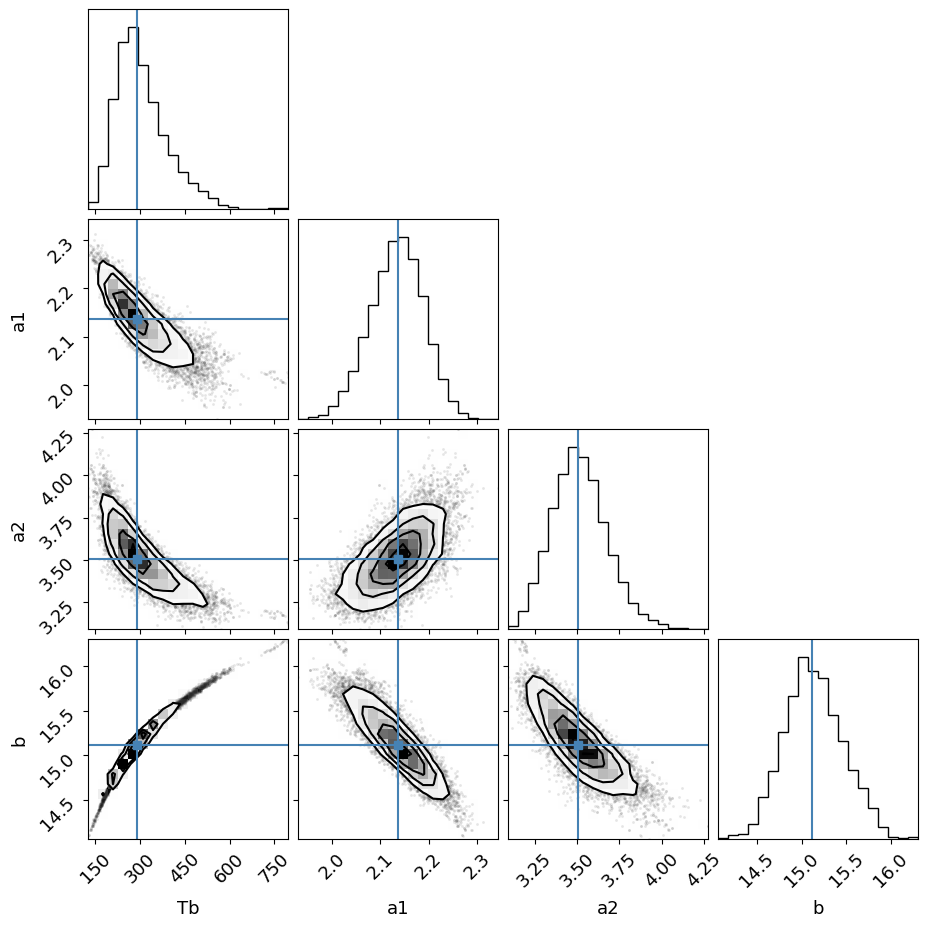

In [54]:

pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["Tb", "a1", "a2", "b"], truths=mcmc[:,1]);



## Fig5: This plot is the marginal paramteric plot the optimium values of the each parameter is given by the histogram plot and the counter plot is the plot for two paramteres. There is some drgree of correlation between the parmeters as seen above.

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in part 2.2 of the current slide deck (slide column 8) https://slides.com/federicabianco/dsps_6#/8. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)
https://slides.com/federicabianco/dsps_6#/8/1 through https://slides.com/federicabianco/dsps_6#/8/3

- implement the caluculation of the AIC (https://slides.com/federicabianco/dsps_6#/8/4 through 6)
- and BIC (https://slides.com/federicabianco/dsps_6#/8/7)



In [55]:
print( f'likehood given line model : {log_likelihood(mcmc_line[:,1], x, y, s):3.2f}') #control the decimal digits!

likehood given line model : -317.42


In [56]:
print( f' Most log_likelihood given bpl as model {log_likelihood_bpl(mcmc[:,1], t, y, s):3.2f}')

 Most log_likelihood given bpl as model -108.77


## Implement the likelihood ration test printing out the likelihood ration statistics

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [57]:
log_likelihood_line_val = log_likelihood(mcmc_line[:,1], x, y, s)
log_likelihood_bpl_val = log_likelihood_bpl(mcmc[:,1], t, y, s)


In [58]:

from scipy.stats.distributions import chi2
def likelihood_ratio(llmin, llmax):
    return(-2*np.log(llmin/llmax))
t1 =(8.225e+00,  2.641e+00)

LR = likelihood_ratio(log_likelihood_bpl(mcmc[:,1], t, y, s),log_likelihood(mcmc_line[:,1], x, y, s))
print(f' Lr : {LR:1.2f}')
dof = 2

p = chi2.sf(LR, dof)
# dof: difference in number of parameters
print ('p: %.30f' % p)
# LR is chi squared distributed:
# p represents the probability that this result
# (or a more extreme result than this)
# would happen by chance


 Lr : 2.14
p: 0.342654566727677523108042123567


##  Hypothesis
Null Hypothesis (H0): The null hypothesis states that the simpler or more restricted model is sufficient to explain the data. In your case, you might specify that the null hypothesis assumes that a certain parameter or set of parameters is equal to specific values or that the simpler model is the true model.

Alternative Hypothesis (H1 or Ha): The alternative hypothesis represents the more complex model, suggesting that it provides a better fit to the data. In your case, it might involve different parameter values or a more complex model.

In [59]:
alpha = 0.05

# Perform the hypothesis test
if p < alpha:
    print("Reject the null hypothesis in favor of the alternative hypothesis. Simpler model doesnot hold")
else:
    print("Fail to reject the null hypothesis. Simpler Model is preferable")

# Print the p-value and test result
print(f"p-value: {p}")

Fail to reject the null hypothesis. Simpler Model is preferable
p-value: 0.3426545667276775


## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [60]:
def aic(N, K , L):
  """
  param L : log likelihood
  K : number of parameters
  N : number of variables
  """
  return -2/(N+10**-5) * (L - K)


def bic(N, K ,L):

  return -2*L +np.log(N)*K


print( f' AIC_line: {aic(5000, 2, log_likelihood_line_val):1.3f}')

print(f' BIC_line: {bic(5000, 2, log_likelihood_line_val):1.3f}')

print( f' AIC_bpl: {aic(5000, 4, log_likelihood_bpl_val):1.3f}')

print(f' BIC_bpl: {bic(5000, 4, log_likelihood_bpl_val):1.3f}')

 AIC_line: 0.128
 BIC_line: 651.877
 AIC_bpl: 0.045
 BIC_bpl: 251.601


In [61]:
print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(5000, 2, log_likelihood_line_val),
                                      aic(5000, 4, log_likelihood_bpl_val)))

print("BIC line {0:.2f} - BIC bpl {1:.2f}".format(bic(5000, 2, log_likelihood_line_val), bic(5000, 4, log_likelihood_bpl_val)))



AIC line 0.13 - AIC bpl 0.05
BIC line 651.88 - BIC bpl 251.60


## Aic test suggest that the bpl model is more preferable as it has lesser value.
Bic cannot diffrentiate

# Extra Credit
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model

BPL model provides a better fit.


<ipython-input-46-b116bf8c5169>:11: RuntimeWarning: divide by zero encountered in reciprocal
  return b - np.log10((x/Tb)**(-a1)+ (x/Tb)**(-a2))
<ipython-input-60-2b1d808e9288>:12: RuntimeWarning: divide by zero encountered in log
  return -2*L +np.log(N)*K
<ipython-input-60-2b1d808e9288>:12: RuntimeWarning: divide by zero encountered in log
  return -2*L +np.log(N)*K
<ipython-input-60-2b1d808e9288>:12: RuntimeWarning: divide by zero encountered in log
  return -2*L +np.log(N)*K
<ipython-input-60-2b1d808e9288>:12: RuntimeWarning: divide by zero encountered in log
  return -2*L +np.log(N)*K
<ipython-input-60-2b1d808e9288>:12: RuntimeWarning: divide by zero encountered in log
  return -2*L +np.log(N)*K
<ipython-input-60-2b1d808e9288>:12: RuntimeWarning: divide by zero encountered in log
  return -2*L +np.log(N)*K


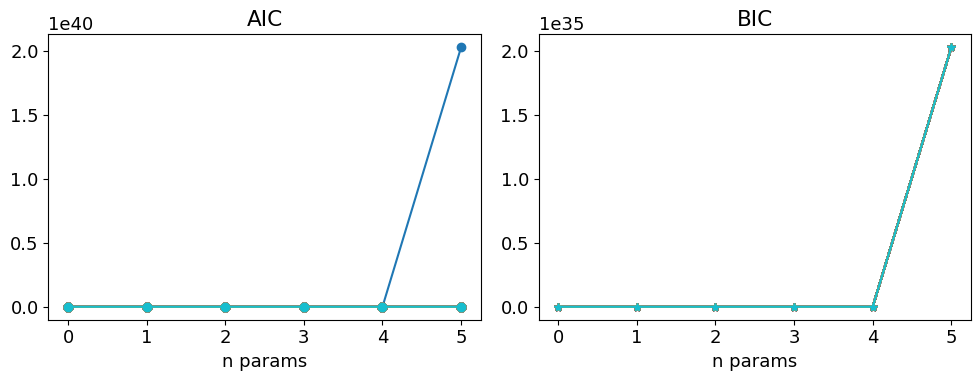

In [62]:
def chi2(pars, x, y, s):
    """
    Calculate the chi-squared values for both a polynomial model and the BPL model.

    Parameters:
    - pars (list): Coefficients of the polynomial model followed by the BPL parameters (Tb, a1, a2, b).
    - x (array-like): Independent variable (time) values.
    - y (array-like): Observed dependent variable (magnitude) values.
    - s (array-like): Uncertainties in the observed values.

    Returns:
    - chi2_poly (float): Chi-squared value for the polynomial model.
    - chi2_bpl (float): Chi-squared value for the BPL model.
    """
    polynomial_coeffs = pars[:-4]
    bpl_params = pars[-4:]

    poly_model = np.polyval(polynomial_coeffs, x)
    chi2_poly = -np.sum(((y - poly_model) / s) ** 2)

    bpl_model = bpl(bpl_params, x)
    chi2_bpl = -np.sum(((y - bpl_model) / s) ** 2)

    return chi2_poly, chi2_bpl

def chi2_poly(params, x, y, s):
    return -np.sum((y - np.polyval(params[::-1], x))**2 / s**2)

# Fake data for illustration (Replace with actual data)
x = np.linspace(0, 10, 100)
y = np.polyval([1, -2, 3], x) + np.random.normal(0, 0.5, x.shape)
s = np.ones_like(x) * 0.5

# Initial guess and model comparison
initialGuess = [1, 1, 1, 1, 1, 1, 1, 1]
chi2_poly_val, chi2_bpl_val = chi2(initialGuess, x, y, s)

if chi2_poly_val < chi2_bpl_val:
    print("Polynomial model provides a better fit.")
else:
    print("BPL model provides a better fit.")

# Fit n-degree polynomials and get AIC/BIC
initialGuess = [10]
aics, bics = [], []

for _ in range(6):
    initialGuess.append(1)

    chi2Solution = minimize(chi2_poly, initialGuess, args=(x, y, s))
    aic_value = aic(x, len(initialGuess), chi2Solution.fun)  # Assuming you've defined aic somewhere
    bic_value = bic(x, len(initialGuess), chi2Solution.fun)  # Assuming you've defined bic somewhere

    aics.append(aic_value)
    bics.append(bic_value)

# print("AIC Values:", aics)
# print("BIC Values:", bics)

fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(10, 4))
ax1.set_title("AIC")
ax1.plot(aics, 'o-')
ax1.set_xlabel("n params")

ax2.set_title("BIC")
ax2.plot(bics, '*-')
ax2.set_xlabel("n params")

pl.tight_layout()
pl.show()